# Fitting in silico Marques to in vivo

**Purpose**: high background noise degrades spike sorting. We characterized in vivo background noise and validated ours against in vivo's.

**Data description**  
**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Neuropixels` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 40.0kHz
    * 10 min
    * "Spontaneous activity" (Only anesthetized condition)


**Summary method**:

* In vivo traces' mean were removed, so we removed the mean from each recording site in silico.
* We fitted in silico preprocessed traces to in vivo preprocessed traces to match the 1) max voltage amplitude and 2) the average background noises per layer (minimum mean absolute deviation). The missing noise was modelled as independent noise on each site.
* The raw silico traces will be scaled and the missing noise added for all subsequent analyses.
* **failed approaches**:
    * applying the scale and missing gaussian noise fitted with preprocessed traces on the raw traces then preprocessing the transformed silico traces, in that order, produces smaller noises per layer than observed in vivo, because high-pass filtering and common referencing remove noise from the traces.
    * rescaling and adding Gaussian noise must be applied to the raw traces, which should then be preprocessed, during each iteration of the fitting procedure. Because the preprocessing of the entire recording is computationally expansive (15 min for 10 min recording), we fitted noise and scale on the first 10 seconds of the in silico recording.

**Pipelines to fit silico amplitude and noise to vivo per layer**:

```bash
sbatch cluster/processing/fitting/marques/fit_marques_silico_l1.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l2_3.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l4.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l5.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l6.sbatch
```

### Setup libs

Activate `npx_10m_384ch_unit_classes` venv

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from concurrent.futures import ProcessPoolExecutor
import copy
import spikeinterface.extractors as se
from scipy.optimize import minimize
import spikeinterface.full as si_full
from contextlib import redirect_stdout
from csv import writer


# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.dataeng.silico import recording, probe_wiring
from src.nodes.prepro import preprocess
from src.nodes.study.layer import getAtlasInfo
from src.nodes.dataeng.silico.probe_wiring import wire_silico_marques_probe

# SETUP PARAMETERS
RND_SEED = 0                # random seed
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_SILICO = 40000        # sampling frequency
WIND_END = 3700             # last segment to calculate mad
SITE_VIVO = 383             # set a site in layer 1 (unbiased estimate of background noise because low activity?)
SITE_SILICO = 360           # set a site in layer 1 (unbiased estimate of background noise because low activity?)
LAYER = "L4"

# HORVATH (vivo)
EXPERIMENT_h_vivo = "vivo_marques"
SIMULATION_h_vivo = "c26"
data_conf_h_vivo, param_conf_h_vivo = get_config(
    EXPERIMENT_h_vivo, SIMULATION_h_vivo
).values() 
RAW_PATH_h_vivo = data_conf_h_vivo["raw"]
PREP_PATH_h_vivo = data_conf_h_vivo["preprocessing"]["output"]["trace_file_path"]
CONTACTS_h = np.arange(0,128,1)


# HORVATH (silico)
EXPERIMENT_h_silico = "silico_neuropixels"
SIMULATION_h_silico = "2023_10_18"
data_conf_h_silico, param_conf_h_silico = get_config(
    EXPERIMENT_h_silico, SIMULATION_h_silico
).values()
RAW_PATH_h_silico = data_conf_h_silico["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_h_silico = data_conf_h_silico["preprocessing"]["output"]["trace_file_path"]
MISSING_NOISE_PATH = data_conf_h_silico["preprocessing"]["fitting"]["missing_noise_path"]
BLUECONFIG = data_conf_h_silico["dataeng"]["blueconfig"]

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/nptyping/typing_.py:51: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  Bool8 = np.bool8
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/nptyping/typing_.py:54: DeprecationWarning: `np.object0` is a deprecated alias for ``np.object0` is a deprecated alias for `np.object_`. `object` can be used instead.  (Deprecated NumPy 1.24)`.  (Deprecated NumPy 1.24)
  Object0 = np.object0
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/nptyping/typing_.py:66: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  Int0 = np.int0
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.

2024-01-05 11:08:49,259 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-05 11:08:49,308 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-01-05 11:08:49,309 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-05 11:08:49,333 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [2]:
### Custom


def get_layer_sites(silico_layers, layer: str = "L1"):
    if layer == "L2_3":
        return np.hstack(
            [np.where(silico_layers == "L2")[0], np.where(silico_layers == "L3")[0]]
        )
    else:
        return np.where(silico_layers == layer)[0]


def plot_example_one_sec_segments(traces, target_site=0, sfreq: int = 30000):
    """plot trace consecutive segments of one second
    Args:
        traces (np.ndarray): ntimepoints x n site traces
        target_site (np.ndarray): column index of a recording site
        sfreq (int): trace acquisition sampling frequency
    Return:
        plot
    """
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    winds = np.arange(0, 10, 1)
    for wind_i in winds:
        axes[wind_i].plot(traces[wind_i * sfreq : (wind_i + 1) * sfreq, target_site])
        axes[wind_i].set_ylim([-200, 200])
    return fig, axes


def measure_noise_at_consecutive_segs(traces, site, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq, site]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


def measure_trace_noise(traces, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second

    Args:
        traces: 2D array
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


def measure_vivo_trace_noise_parallel(traces_vivo, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_vivo (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_vivo, SFREQ_VIVO, WIND_END))


def measure_silico_trace_noise_parallel(traces_silico, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_silico (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_silico, SFREQ_SILICO, WIND_END))


Nfeval = 1


def myfun(missing_mad_std, *args):
    # get arguments
    trace_silico = args[0]
    mad_vivo = args[1]
    site_silico = args[2]

    # calculate missing noise for this x
    missing_noise = np.random.normal(0, missing_mad_std, [trace_silico.shape[0], 1])

    # return objective function abs(mad_vivo - mad_silico) to minimize
    mad_silico = (
        pd.DataFrame(trace_silico[:, site_silico] + missing_noise.squeeze())
        .mad()
        .values
    )
    return abs(mad_vivo - mad_silico)


def myfun_layer(missing_noise, *args):
    """_summary_

    Args:
        missing_noise (np.float): _description_
        args:
        - args[0] (np.array): voltage traces (nsites x ntimepoints)

    Returns:
        _type_: _description_
    """
    # get args
    # - get in silico target site traces
    # - get in vivo layer noise
    silico_traces = args[0]  # nsites x ntimepoints
    vivo_noise = args[1]
    gain = args[2]
    fit_history_path = args[3]
    data_conf = args[4]
    param_conf = args[5]
    silico_layers = args[6]
    layer = args[7]

    SCALE_FOR_FIT = 10e4

    FREQ_MIN = param_conf["run"]["preprocessing"]["min_filter_freq"]
    FREQ_MAX = param_conf["run"]["preprocessing"]["max_filter_freq"]

    ntimepoints = silico_traces.shape[1]
    nsites = silico_traces.shape[0]

    # set seed for reproducibility
    np.random.seed(RND_SEED)

    # test amount of missing independent noise in silico
    missing_noise_traces = np.random.normal(
        0, missing_noise / SCALE_FOR_FIT, [nsites, ntimepoints]
    )
    scaled_and_noised = silico_traces * gain + missing_noise_traces

    # cast, rewire and preprocess
    WithNoise = se.NumpyRecording(
        traces_list=[scaled_and_noised.T],
        sampling_frequency=SFREQ_SILICO,
    )
    WithNoise = wire_silico_marques_probe(data_conf, WithNoise)
    Bandpassed = si_full.bandpass_filter(
        WithNoise, freq_min=FREQ_MIN, freq_max=FREQ_MAX
    )
    Preprocessed = si_full.common_reference(
        Bandpassed, reference="global", operator="median"
    )
    traces_silico = Preprocessed.get_traces()

    # get in silico traces for this layer
    layer_sites = get_layer_sites(silico_layers, layer)
    silico_traces = traces_silico[:, layer_sites]

    # measure site noises in that layer
    nsites = silico_traces.shape[1]
    with ProcessPoolExecutor() as executor:
        sites_noise = executor.map(
            measure_silico_trace_noise_parallel,
            silico_traces.T,
            np.arange(0, nsites, 1),
        )

    # minimize noise difference between vivo and silico
    silico_noise = np.mean(np.array(list(sites_noise)))
    objfun = abs(vivo_noise - silico_noise)

    # save minimization history
    with open(fit_history_path + ".txt", "a") as f:
        with redirect_stdout(f):
            print("silico noise:", silico_noise)
            print("vivo noise:", vivo_noise)
            print("missing noise:", missing_noise)
            print("gain:", gain)
            print("objfun:", objfun)
            print("----------------")

    # List that we want to add as a new row
    List = [silico_noise, vivo_noise, missing_noise[0], gain, objfun]

    # Open our existing CSV file in append mode
    # Create a file object for this file
    with open(fit_history_path + ".csv", "a") as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(List)
        f_object.close()

    # print history in terminal
    with open(fit_history_path + ".txt", "r") as f:
        contents = f.read()
        print(contents)
    return objfun


def callback(Xi):
    """callback function to print iterations_summary

    Args:
        Xi (_type_): missing noise (mad) parameter to solve
    """
    global Nfeval  # function evaluation
    print(Xi)
    print("{0:4d}   {1: 3.6f}".format(Nfeval, Xi[0]))
    Nfeval += 1


def sem(data):
    return np.std(data) / np.sqrt(len(data))


def conf_interv95(data):
    return 1.96 * sem(data)


def label_layers(WiredRecording):
    """add site layers metadata

    Args:
        WiredRecording (_type_): _description_

    Returns:
        _type_: _description_
    """
    probe = WiredRecording.get_probe()
    _, site_layers = getAtlasInfo(BLUECONFIG, probe.contact_positions)
    WiredRecording.set_property("layers", values=site_layers)
    return WiredRecording

In [3]:
# takes 1 min

PERIOD_SECS = 2
period = np.arange(0, SFREQ_SILICO * PERIOD_SECS, 1)

# load raw
RawRecording = pd.read_pickle(RAW_PATH_h_silico)
raw_traces = RawRecording.iloc[period, :]

# cast as extractor
Recording = se.NumpyRecording(
    traces_list=[np.array(raw_traces)],
    sampling_frequency=SFREQ_SILICO,
)

# wire and add metadata
WiredSilicoRecording = wire_silico_marques_probe(data_conf_h_silico, Recording)
WiredSilicoRecording = label_layers(WiredSilicoRecording)


# get traces
# load preprocessed in vivo traces
PreRecording_h_vivo = si.load_extractor(PREP_PATH_h_vivo)
traces_vivo = PreRecording_h_vivo.get_traces()

# get raw silico traces
silico_traces = WiredSilicoRecording.get_traces()


# get site layers
silico_layers = WiredSilicoRecording.get_property("layers")
vivo_layers = PreRecording_h_vivo.get_property("layers")


# calculate gain
gain = traces_vivo.max() / silico_traces.max()


# measure the mean site noises for this layer
vivo_traces = traces_vivo[:, np.where(vivo_layers == LAYER)[0]].T
nsites = vivo_traces.shape[0]
with ProcessPoolExecutor() as executor:
    traces_noise = executor.map(
        measure_vivo_trace_noise_parallel,
        vivo_traces,
        np.arange(0, nsites, 1),
    )
vivo_traces_noise = list(traces_noise)
vivo_layer_noise = np.mean(np.array(vivo_traces_noise))
print("measured noise (in vivo):", vivo_layer_noise)

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


measured noise (in vivo): 2.7881723363496267


In [4]:
# takes 18 min

# FIT
SCALE_FOR_FIT = 10e4
X0 = 2.5 * SCALE_FOR_FIT  # 6.7e-02 * SCALE_FOR_FIT
MAX_ITER = 15
TOL = 0.01

# create fit output .csv file
List = ["silico_noise", "vivo_noise", "missing_noise", "gain", "objfun"]

with open(PROJ_PATH + "fit_history.csv", "w") as file:
    writer_object = writer(file)
    writer_object.writerow(List)
    file.close()

# fit
results = minimize(
    myfun_layer,
    X0,
    args=(
        silico_traces.T,
        vivo_layer_noise,
        gain,
        PROJ_PATH + "fit_history",
        data_conf_h_silico,
        param_conf_h_silico,
        silico_layers,
        LAYER,
    ),
    method="Nelder-Mead",
    tol=TOL,
    callback=callback,
    options={"maxiter": MAX_ITER, "disp": True},
)

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174
objfun: 2.6487548337925255
----------------
silico noise: 4.6788679847881305
vivo noise: 2.027459498703704
gain: 189.06866640281
objfun: 2.6514084860844265
----------------
silico noise: 4.6762143324962295
vivo noise: 2.027459498703704
gain: 179.98253812049174


/tmp/ipykernel_113106/3193889525.py:18: RuntimeWarning: Maximum number of iterations has been exceeded.
  results = minimize(


In [5]:
# check fit history
fit_out = pd.read_csv(PROJ_PATH + "fit_history.csv")
fit_out

,silico_noise,vivo_noise,missing_noise,gain,objfun
0,1.991241,2.788172,250000.000000,81.83955,0.796931
1,2.088612,2.788172,262500.000000,81.83955,0.699560
2,2.186072,2.788172,275000.000000,81.83955,0.602100
3,2.283613,2.788172,287500.000000,81.83955,0.504559
4,2.478879,2.788172,312500.000000,81.83955,0.309293
5,2.674362,2.788172,337500.000000,81.83955,0.113810
6,3.065842,2.788172,387500.000000,81.83955,0.277670
7,2.870028,2.788172,362500.000000,81.83955,0.081856
8,3.065842,2.788172,387500.000000,81.83955,0.277670
9,2.772176,2.788172,350000.000000,81.83955,0.015996


In [6]:
# get best missing noise and gain parameters
ix_best_fitp = np.argmin(fit_out["objfun"])
best_params = fit_out.iloc[ix_best_fitp, :]
missing_noise = np.float64(best_params["missing_noise"]) / SCALE_FOR_FIT
gain = np.float64(best_params["gain"])

print(gain)
print(missing_noise)

81.83955
3.5203857421875


In [7]:
# takes 30 secs

# reconstruct fitted traces and noises

# get params
FREQ_MIN = param_conf_h_silico["run"]["preprocessing"]["min_filter_freq"]
FREQ_MAX = param_conf_h_silico["run"]["preprocessing"]["max_filter_freq"]
nsites = silico_traces.T.shape[0]
ntimepoints = silico_traces.T.shape[1]


# set seed for reproducibility
np.random.seed(RND_SEED)

# test amount of missing independent noise in silico
missing_noise_traces = np.random.normal(
    0, missing_noise, [nsites, silico_traces.T.shape[1]]
)
scaled_and_noised = silico_traces.T * gain + missing_noise_traces

# cast, rewire and preprocess
WithNoise = se.NumpyRecording(
    traces_list=[scaled_and_noised.T],
    sampling_frequency=SFREQ_SILICO,
)
WithNoise = wire_silico_marques_probe(data_conf_h_silico, WithNoise)
Bandpassed = si_full.bandpass_filter(WithNoise, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
Preprocessed = si_full.common_reference(
    Bandpassed, reference="global", operator="median"
)
traces_silico = Preprocessed.get_traces()

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


### Compute layer-wise noise

In [8]:
# takes 13 min (instead of 2 hours)

# VIVO

# measure site noise of in vivo traces (parallelized, )
with ProcessPoolExecutor() as executor:
    noise_by_trace = executor.map(
        measure_vivo_trace_noise_parallel,
        traces_vivo.T,
        np.arange(0, traces_vivo.shape[1], 1),
    )
vivo_noise_by_trace = list(noise_by_trace)

# SILICO

# measure site noise of fitted silico traces
with ProcessPoolExecutor() as executor:
    silico_noise_by_trace = executor.map(
        measure_silico_trace_noise_parallel,
        traces_silico.T,
        np.arange(0, traces_silico.shape[1], 1),
    )
silico_noise_by_trace = list(silico_noise_by_trace)

### Plot

Text(0, 0.5, 'Background noise (uV)')

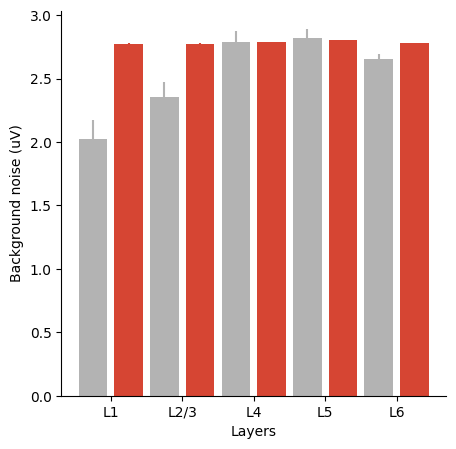

In [9]:
# plot layer-wise noise for vivo vs. silico

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

layers = ["L1", "L2_3", "L4", "L5", "L6"]
vivo_noise = []
ci_vivo = []
sili_noise = []
ci_sili = []

# calculate noise stats by layer
for l_i in range(len(layers)):
    # VIVO
    vivo_noise.append(
        np.mean(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])
    )
    ci_vivo.append(
        conf_interv95(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])
    )

    # SILICO
    sites = get_layer_sites(silico_layers, layer=layers[l_i])
    sili_noise.append(np.mean(np.array(silico_noise_by_trace)[sites]))
    ci_sili.append(conf_interv95(np.array(silico_noise_by_trace)[sites]))


# VIVO

ax.errorbar(
    x=[1, 2, 3, 4, 5],
    y=vivo_noise,
    yerr=ci_vivo,
    linestyle="None",
    color=[0.7, 0.7, 0.7],
)
ax.bar(
    x=[1, 2, 3, 4, 5],
    height=vivo_noise,
    width=0.4,
    facecolor=[0.7, 0.7, 0.7],
)
ax.set_xticks([1, 2, 3, 4, 5])

# SILICO

ax.errorbar(
    x=[1.5, 2.5, 3.5, 4.5, 5.5],
    y=sili_noise,
    yerr=ci_sili,
    linestyle="None",
    color=(0.84, 0.27, 0.2),
)
ax.bar(
    x=[1.5, 2.5, 3.5, 4.5, 5.5],
    height=sili_noise,
    width=0.4,
    facecolor=(0.84, 0.27, 0.2),
)

ax.set_xticks([1.25, 2.25, 3.25, 4.25, 5.25])
ax.set_xticklabels(["L1", "L2/3", "L4", "L5", "L6"])
# ax.set_ylim([1.8, 3])
ax.set_box_aspect(1)  # square axis
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlabel("Layers")
ax.set_ylabel("Background noise (uV)")

# # # save figures
# plt.savefig("figures/2_realism/2_noise/pdf/layerwise_noise_stats_marques.pdf")
# plt.savefig("figures/2_realism/2_noise/svg/layerwise_noise_stats_marques.svg")

### Sanity check

In [ ]:
# sanity check that max amplitude before and after preprocessing are close
# this is to fix a single gain parameter, calculated from preprocessed traces in advance
# calculating gain during the optimization after adding missing noise is difficult
# as one can increase trace noise both by increasing gain or by increasing missing noise rms

# max voltage preprocessed ----
FREQ_MAX = param_conf_h_silico["run"]["preprocessing"]["max_filter_freq"]
FREQ_MIN = param_conf_h_silico["run"]["preprocessing"]["min_filter_freq"]

# get raw traces
raw = RawRecording.values[:, :384]

# cast, rewire and preprocess
preprocessed = se.NumpyRecording(
    traces_list=[raw],
    sampling_frequency=SFREQ_SILICO,
)
preprocessed = wire_silico_marques_probe(data_conf_h_silico, preprocessed)
preprocessed = si_full.bandpass_filter(
    preprocessed, freq_min=FREQ_MIN, freq_max=FREQ_MAX
)
preprocessed = si_full.common_reference(
    preprocessed, reference="global", operator="median"
)
traces_silico = preprocessed.get_traces()
print(traces_silico.max())

# check max amplitudes
for ix in range(raw.shape[1]):
    raw[:, ix] = raw[:, ix] - raw[:, ix].mean()
print(raw.max())

print(traces_silico.max())

# references

https://en.wikipedia.org/wiki/Noise_(electronics)